In [1]:
from time import time

import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import math
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms
from torch.autograd import Variable

import onlinehd

SEED = 1234
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from tensorflow.keras.datasets import fashion_mnist
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pylab as pl
from IPython import display
%matplotlib inline

# Dataset

In [3]:
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

class CustomImageDataset(Dataset):
    def __init__(self, df, data_type = 'train', model_type='ffnn'):
        """
        :param df: data frame
        :param rating_2014_file: 'train'/'test'
        :param model_type: 'ffnn'/'cnn'
        """
        if data_type == 'train':
            self.X = df.drop('label', axis=1).values/255.
            self.Y = df['label'].values
        else:
            self.X = df.values/255.
            self.Y = None
        self.X = torch.from_numpy(self.X.astype(np.float32)).reshape(len(df),28, 28)
        self.data_type = data_type
        self.model_type = model_type

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        image = self.X[idx]
        if self.data_type == 'train':
            label = self.Y[idx]
        else:
            label = None
        
        if self.model_type == 'ffnn':
            return image, label
        else:
            # add additional dimension if we need dataset for cnn
            return image.unsqueeze(0), label

In [4]:
(x, y), (x_test, y_test) = fashion_mnist.load_data()

In [5]:
x = x.astype(np.float)
x_test = x_test.astype(np.float)
y = y.astype(np.long)
y_test = y_test.astype(np.long)

/var/folders/4_/4812b_4j2_s0smfmxlqdpr600000gn/T/ipykernel_13160/860525519.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.astype(np.float)
/var/folders/4_/4812b_4j2_s0smfmxlqdpr600000gn/T/ipykernel_13160/860525519.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test = x_test.astype(np.float)
/var/folders/4_/4812b_4j2_s0sm

In [6]:
scaler = sklearn.preprocessing.Normalizer().fit(x.reshape(-1, 784))

In [7]:
x = x.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

df_train = pd.DataFrame(x)
df_val = pd.DataFrame(x_test)

df_train['label'] = y
df_val['label'] = y_test

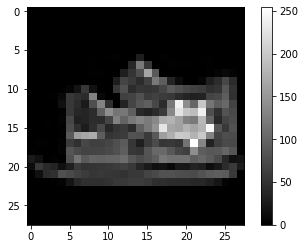

In [8]:
plt.imshow(x_test[-1].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

# Load CNN model

In [9]:
# convolutional nn
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # input torch.Size([64, 1, 28, 28])
        # torch.Size([batch_size, channels, img_width, img_height])
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4)
        # torch.Size([64, 16, 28-kernel_size+1, 28-kernel_size+1])
        # torch.Size([64, 16, 25, 25])
        self.relu1=nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=2)
        
        # torch.Size([64, 8, 24, 24])
        self.relu2=nn.ReLU()
        self.max_pool2=nn.MaxPool2d(kernel_size=2)
        
        # torch.Size([64, 8, 12, 12])
        self.fc1 = nn.Linear(8*12*12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        
        out=self.conv1(x)
        out=self.relu1(out)
        
        out=self.conv2(out)
        out=self.relu2(out)
        out=self.max_pool2(out)
        
        out = torch.flatten(out, 1)
        out=self.fc1(out)
        out=self.fc2(out)
        return out

In [10]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn, result_dict):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    result_dict['avg_loss'].append(test_loss)
    result_dict['acc'].append(correct)
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
def plot_results(axs, res_dict):
    
    axs[0].plot(res_dict['epoch'][-10:], res_dict['acc'][-10:], c='r')
    axs[0].set_title('Validation accuracy {:.4f}'.format(res_dict['acc'][-1]))
    
    axs[1].plot(res_dict['epoch'][-10:], res_dict['avg_loss'][-10:], c='r')
    axs[1].set_title('Average validation loss {:.4f}'.format(res_dict['avg_loss'][-1]))
    display.clear_output(wait=True)
    display.display(plt.gcf())

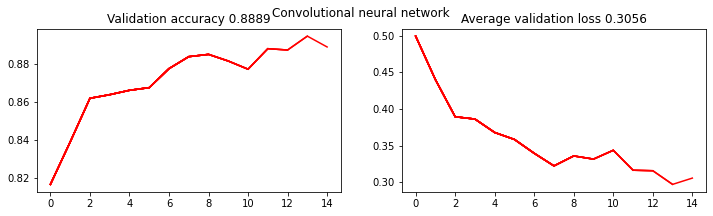

Epoch 16
-------------------------------
loss: 0.366623  [    0/60000]
loss: 0.195300  [12800/60000]
loss: 0.365347  [25600/60000]
loss: 0.245367  [38400/60000]
loss: 0.314215  [51200/60000]
INFO: Early stopping counter 5 of 5
INFO: Early stopping


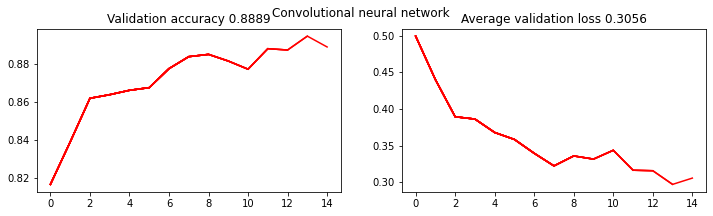

In [11]:
BATCH_SIZE = 128
EPOCHS = 30

training_data = CustomImageDataset(df_train, model_type='cnn')
val_data = CustomImageDataset(df_val, model_type='cnn')
# create Dataloader for cnn
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

model_cnn = CNN().to(device)
print(model_cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.0005)
early_stop_callback = EarlyStopping()

fig, axs = plt.subplots(1,2, figsize=(12,3))
plt.suptitle('Convolutional neural network')
result = {'avg_loss':[], 'acc':[], 'epoch':[]}

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_cnn, loss_fn, optimizer)
    test(val_dataloader, model_cnn, loss_fn, result)
    result['epoch'].append(t)
    early_stop_callback(result['avg_loss'][-1])
    if early_stop_callback.early_stop:
        break
    plot_results(axs, result)

In [12]:
model = model_cnn
dataloader = val_dataloader

size = len(dataloader.dataset)
num_batches = len(dataloader)
model.eval()
test_loss, correct = 0, 0

with torch.no_grad():
    for X, y_ in dataloader:
        X, y_ = X.to(device), y_.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y_).item()
        correct += (pred.argmax(1) == y_).type(torch.float).sum().item()

test_loss /= num_batches
correct /= size

test_loss, correct

(0.3003505094896389, 0.8934)

# Generate DeepFool samples

In [41]:
import numpy as np
from torch.autograd import Variable
import torch as torch
import copy
#from torch.autograd.gradcheck import zero_gradients

def zero_gradients(x):
    if isinstance(x, torch.Tensor):
        if x.grad is not None:
            x.grad.detach_()
            x.grad.zero_()
    elif isinstance(x, collections.abc.Iterable):
        for elem in x:
            zero_gradients(elem)

is_cuda = torch.cuda.is_available()

def deepfool(image, net, num_classes = 10, overshoot=0.02, max_iter=10):

    """
       :param image: Image of size HxWx3
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """


    f_image = net.forward(Variable(image[None, :, :, :], requires_grad=True)).data.cpu().numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image[None, :], requires_grad=True)
    fs = net.forward(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = image.max().item()
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            zero_gradients(x)

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / (np.linalg.norm(w)+0.001)
        r_tot = np.float32(r_tot + r_i)*3

        
        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)
        
        x = Variable(pert_image, requires_grad=True)
        fs = net.forward(x.reshape(1,1,28,28))
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    #r_tot = (1+overshoot)*r_tot

    return pert_image, torch.from_numpy(r_tot)#, loop_i, label, k_i,

In [42]:
x_test = torch.tensor(x_test).float()

/var/folders/4_/4812b_4j2_s0smfmxlqdpr600000gn/T/ipykernel_13160/2527913332.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test).float()


In [43]:
X_te_cln = x_test.reshape(-1, 1, 28, 28)

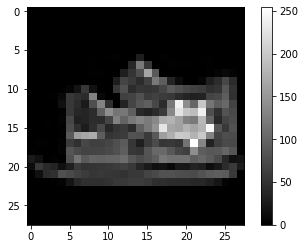

In [44]:
plt.imshow(X_te_cln[-1].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

In [48]:
x_test_adv = torch.zeros(X_te_cln.shape)
x_test_pert = torch.zeros(10000, 28, 28)

model_cnn.cpu()
for i in tqdm(range(10000)):
    x_test_adv[i], x_test_pert[i] = deepfool(X_te_cln[i].reshape(1, 28, 28), model_cnn)

100%|█████████████████████████████████████| 10000/10000 [04:04<00:00, 40.92it/s]


In [46]:
sum(torch.from_numpy(y_test[:1000]).long() == (model(x_test_adv[:1000]/255.)).argmax(1)) / 1000

tensor(0.4440)

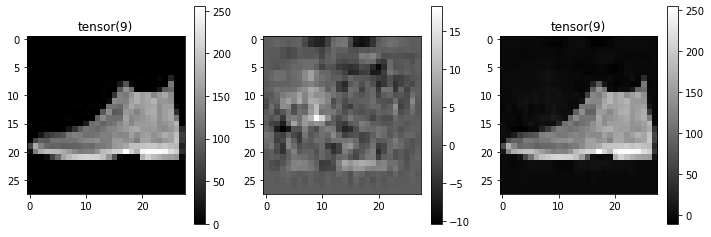

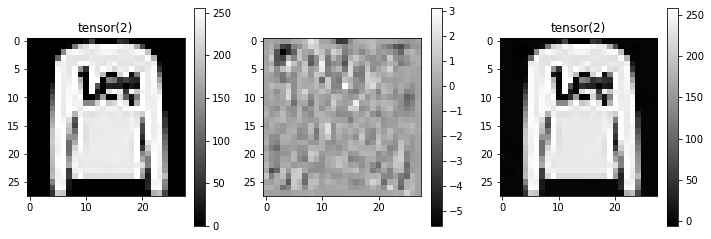

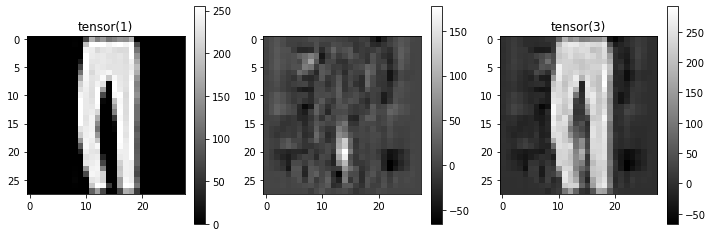

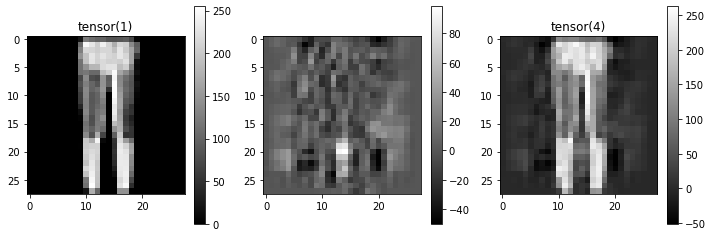

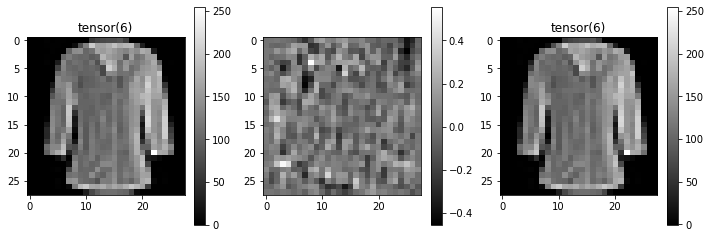

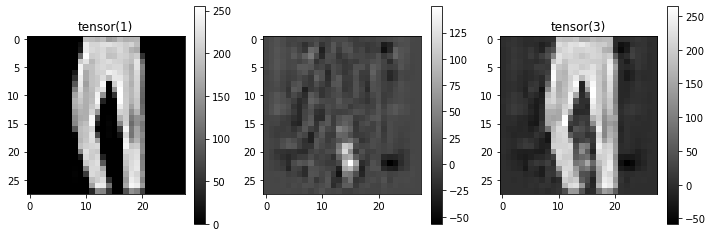

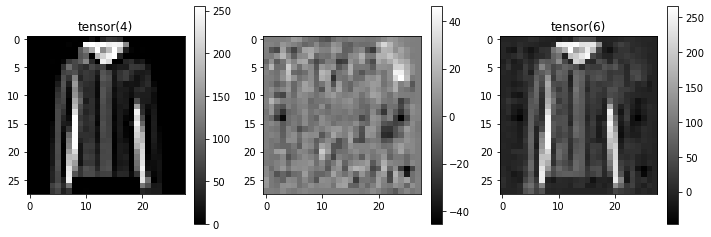

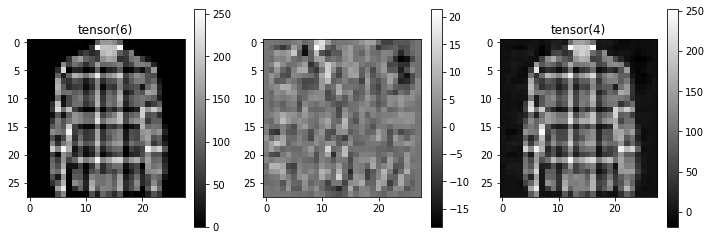

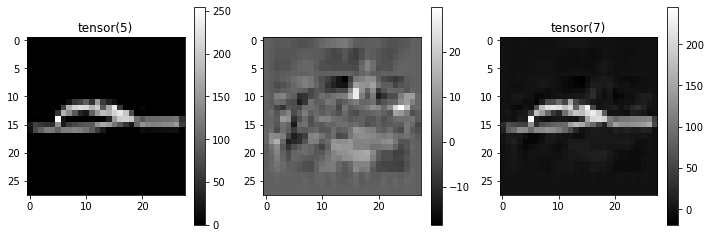

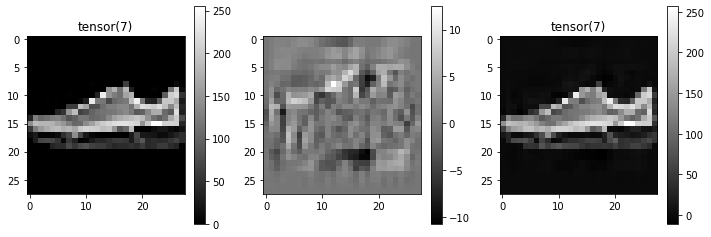

In [49]:
for i in range(10):

    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(model_cnn((x_test[i]/255.).reshape(1,1,28,28)).argmax())
    plt.colorbar()
    
    plt.subplot(132)
    plt.imshow(x_test_pert[i].reshape(28, 28), cmap='gray')
    plt.colorbar()
    
    plt.subplot(133)
    plt.imshow(x_test_adv[i].reshape(28, 28), cmap='gray')
    plt.title(model_cnn((x_test_adv[i]/255.).reshape(1,1,28,28)).argmax())
    plt.colorbar()
    
    plt.show()

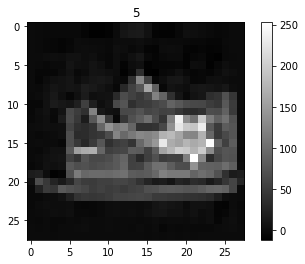

In [50]:
plt.imshow(x_test_adv[-1].reshape(28, 28), cmap='gray')
plt.title(y_test[-1].item())
plt.colorbar()
plt.show()

# save samples

In [51]:
attack_sample = x_test_adv.reshape(-1, 784)
attack_sample.shape

torch.Size([10000, 784])

In [52]:
import pickle 

sample = {
    'data':attack_sample,
    'label':y_test
}

with open('FMNIST_cnn_DF.pickle', 'wb') as f:
    pickle.dump(sample, f)

In [53]:
with open('FMNIST_cnn_DF.pickle', 'rb') as f:
    sample = pickle.load(f)
    
attack_sample = sample['data']
attack_label = sample['label']

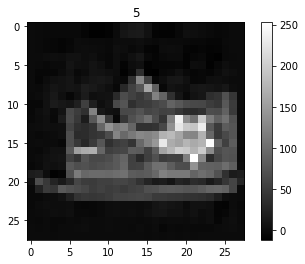

In [54]:
plt.imshow(attack_sample[-1].reshape(28, 28), cmap='gray')
plt.title(y_test[-1].item())
plt.colorbar()
plt.show()

# Sample Test

In [55]:
df_test = pd.DataFrame(attack_sample.numpy())
df_test['label'] = y_test

Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


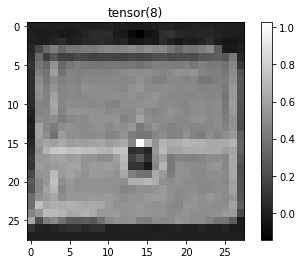

In [56]:
BATCH_SIZE = 128
EPOCHS = 30

# load dataa
# df_train, df_val = train_test_split(df, test_size=0.2)

# create Dataset
test_data = CustomImageDataset(df_test, model_type='cnn')

# create Dataloader
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# Display image and label.
test_features, test_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")

img = test_features[0].squeeze()
label = test_labels[0]
plt.imshow(img, cmap="gray")
plt.title(label)
plt.colorbar()
plt.show()

In [57]:
model = model_cnn
dataloader = test_dataloader

loss_fn = nn.CrossEntropyLoss()

size = len(dataloader.dataset)
num_batches = len(dataloader)
model.eval()
test_loss, correct = 0, 0

with torch.no_grad():
    for X, y_ in dataloader:
        X, y_ = X.to(device), y_.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y_).item()
        correct += (pred.argmax(1) == y_).type(torch.float).sum().item()

test_loss /= num_batches
correct /= size

test_loss, correct

(3.294696512101572, 0.4333)